In [1]:
# 패키지 임포트
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

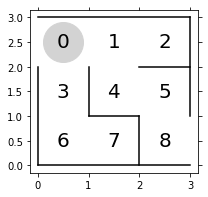

In [2]:
# 미로 생성
fig = plt.figure(figsize=(3, 3))

# 벽
plt.plot([0, 3], [3, 3], color='k')
plt.plot([0, 3], [0, 0], color='k')
plt.plot([0, 0], [0, 2], color='k')
plt.plot([3, 3], [1, 3], color='k')
plt.plot([1, 1], [1, 2], color='k')
plt.plot([2, 3], [2, 2], color='k')
plt.plot([2, 1], [1, 1], color='k')
plt.plot([2, 2], [0, 1], color='k')

# 숫자
for i in range(3):
    for j in range(3):
        plt.text(0.5+i, 2.5-j, str(i+j*3), size=20, ha='center', va='center')

# 원
circle, = plt.plot([0.5], [2.5], marker='o', color='#d3d3d3', markersize=40)

# 눈금과 테두리 숨기기
plt.tick_params(axis='both', which='both', bottom='off', top= 'off',
        labelbottom='off', right='off', left='off', labelleft='off')
plt.box('off')

In [3]:
# 파라미터 θ의 초기값 준비
theta_0 = np.array([
    [np.nan, 1, 1, np.nan], # 0
    [np.nan, 1, 1, 1], # 1
    [np.nan, np.nan, np.nan, 1], # 2
    [1, np.nan, 1, np.nan], # 3
    [1, 1, np.nan, np.nan], # 4
    [np.nan, np.nan, 1, 1], # 5
    [1, 1, np.nan, np.nan], # 6
    [np.nan, np.nan, np.nan, 1]]) # 7

# 파라미터 θ를 정책으로 변환
def get_pi(theta):
    # 비율 계산
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
    pi = np.nan_to_num(pi)    
    return pi

# 파라미터 θ의 초기값을 정책으로 변환
pi_0 = get_pi(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         1.        ]
 [0.5        0.         0.5        0.        ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.         1.        ]]


In [4]:
# 행동 가치 함수 준비
[a, b] = theta_0.shape
Q = np.random.rand(a, b) * theta_0 * 0.01
print(Q)

[[       nan 0.00057313 0.0066749         nan]
 [       nan 0.00471676 0.00610839 0.00918327]
 [       nan        nan        nan 0.00198653]
 [0.00151973        nan 0.00890222        nan]
 [0.00695988 0.005384          nan        nan]
 [       nan        nan 0.00352429 0.00336126]
 [0.00049702 0.00909092        nan        nan]
 [       nan        nan        nan 0.00748859]]


In [5]:
# 행동에 따라 다음 상태 얻기
def get_s_next(s, a):
    if a == 0: # 상
        return s - 3
    elif a == 1: # 우
        return s + 1
    elif a == 2: # 하
        return s + 3
    elif a == 3: # 좌
        return s - 1

In [6]:
# 랜덤 또는 행동 가치 함수에 따라 행동 얻기
def get_a(s, Q, epsilon, pi_0):
    if np.random.rand() < epsilon:
        # 랜덤으로 행동을 선택
        return np.random.choice([0, 1, 2, 3], p=pi_0[s])
    else:
        # 행동 가치 함수로 행동을 선택
        return np.nanargmax(Q[s])

In [7]:
# Sarsa에 따른 행동 가치 함수 갱신
def sarsa(s, a, r, s_next, a_next, Q):
    eta = 0.1 # 학습 계수
    gamma = 0.9 # 시간 할인율
    
    if s_next == 8:
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])
    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * Q[s_next, a_next] - Q[s, a])
    return Q

In [8]:
# Q 학습에 따른 행동 가치 함수 갱신
def q_learning(s, a, r, s_next, a_next, Q):
    eta = 0.1 # 학습 계수
    gamma = 0.9 # 시간 할인율
    
    if s_next == 8:
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])
    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanmax(Q[s_next, :]) - Q[s, a])
    return Q

In [9]:
# 1 에피소드 실행
def play(Q, epsilon, pi):
    s = 0 # 상태
    a = a_next = get_a(s, Q, epsilon, pi) # 행동 초기값
    s_a_history = [[0, np.nan]] # 상태와 행동 이력

    # 에피소드 완료 시까지 반복
    while True:
        # 행동에 따른 다음 상태 얻기=
        a = a_next
        s_next = get_s_next(s, a)

        # 이력 갱신
        s_a_history[-1][1] = a
        s_a_history.append([s_next, np.nan])

        # 종료 판정
        if s_next == 8:
            r = 1
            a_next = np.nan
        else:
            r = 0
            # 행동 가치 함수 Q에 따라 행동 얻기
            a_next = get_a(s_next, Q, epsilon, pi)

        # 행동 가치 함수 갱신 (* Q 학습 시에는 q_learning으로 변경)
        Q = sarsa(s, a, r, s_next, a_next, Q)
        # Q = q_learning(s, a, r, s_next, a_next, Q)
        
        # 종료 판정
        if s_next == 8:
            break
        else:
            s = s_next

    # 이력과 행동 가치 함수 반환
    return [s_a_history, Q]

In [10]:
epsilon = 0.5  # ε-greedy에서의 ε의 초기값

# 에피소드를 반복해서 실행하며 학습
for episode in range(10):
    # ε-greedy값을 점점 감소시킴
    epsilon = epsilon / 2

    # 1 에피소드 실행해 이력과 행동 가치 함수 얻기
    [s_a_history, Q] = play(Q, epsilon, pi_0)
    
    # 출력
    print('에피소드: {}, 스텝: {}'.format(
        episode, len(s_a_history)-1))

에피소드: 0, 스텝: 402
에피소드: 1, 스텝: 12
에피소드: 2, 스텝: 4
에피소드: 3, 스텝: 4
에피소드: 4, 스텝: 4
에피소드: 5, 스텝: 4
에피소드: 6, 스텝: 4
에피소드: 7, 스텝: 4
에피소드: 8, 스텝: 4
에피소드: 9, 스텝: 4


In [11]:
# 애니메이션 정기 처리 수행 함수
def animate(i):
    state = s_a_history[i][0]
    circle.set_data((state % 3) + 0.5, 2.5 - int(state / 3))
    return circle

# 애니메이션 표시
anim = animation.FuncAnimation(fig, animate, \
        frames=len(s_a_history), interval=200, repeat=False)
HTML(anim.to_jshtml())